<a href="https://colab.research.google.com/github/rfarwell/MPhys/blob/main/CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [1]:
!pip install torch torchvision
!pip install SimpleITK

import os

import SimpleITK as sitk

import random

import torch
from torch import reshape
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Since we're on COLAB we need to connect to Google Drive in order to access the files

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Then mount to a specific folder, the one with all the data in.

In [3]:
project_folder = "/content/gdrive/MyDrive/MPhys/Data"
clinical_data_filename = "COLAB-Clinical-Data.csv"
print(os.path.join(project_folder, clinical_data_filename))

/content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv


We now connect to a GPU if one is available, if not we will use cpu.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Defining Hyperparamters for the CNN
A few lines defining sertain hyperparameters for the CNN to use.

In [5]:
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# Define arrays of patient and outcome data

Define functions will be used later in this code:

In [6]:
def equalise_array_lengths(array_1, array_2) :
  """
  This function takes in the arguments of two lists and makes sure they are returned as the same length.

  Rory Farwell 02/12/2021
  """
  # output_array = []
  if len(array_1) > len(array_2) :
    array_1 = array_1[:len(array_2)]
  elif len(array_1) < len(array_2) :
    array_2 = array_2[:len(array_1)]
  #print(np.vstack((array_1, array_2)))
  # output_array.append(array_1)
  # output_array.append(array_2)
  return (array_1, array_2)

def remove_same_elements(small_array, long_array) :
  """
  For use in the context, all the elements in small_array come from long_array.
  This function will remove all of the elements used in small_array from_long_array.  
  """
  for element in small_array :
    long_array.remove(element)
  return long_array

def create_subgroup(input_array, original_array_length, desired_percentage) :
  """
  This function outputs a subgroup array (e.g. training array) using a specified output array name,
  input array and percentage length
  """
  desired_length = int(original_array_length * desired_percentage)
  output_array = random.sample(input_array, desired_length)
  return output_array
  

First, open the metadata.csv file which has the patient status at a certain timepoint

In [7]:
# Open the metadata.csv file, convert to an array, and remove column headers
metadata_file = os.path.join(project_folder, clinical_data_filename)
metadata = np.genfromtxt(metadata_file, comments = '%', dtype="str", delimiter=",")
print(f"Length of metadata array is {len(metadata)}")

Length of metadata array is 100


In [8]:
check_day = 365 * 1.5 # This is defining the timeframe for which our CNN will consider the binary output (in days)

patient_IDs = metadata[:,0]
time_markers = metadata[:,8]
dead_statuses = metadata[:,9]

time_markers = time_markers.astype(np.float32)
dead_statuses = dead_statuses.astype(np.float32)

Now, create dead and alive arrays for the given timepoint check_day.

In [9]:
check_day_dead_statuses = []

counter = 0 

dead_counter = 0
alive_counter = 0
no_info_counter = 0

dead_patient_array = []
alive_patient_array = []

for i in range(len(dead_statuses)) :
  # counter+=1
  # print(counter)
  temp_dead_status = dead_statuses[i]
  #print(temp_dead_status)
  temp_time_marker = time_markers[i]
  #print(temp_time_marker)
  if temp_dead_status == 1 : #if the patient is dead
    #print('y')
    if temp_time_marker < check_day :
      check_day_dead_statuses.append(1) #confirms that the patient was dead after time 'check_day'
      dead_patient_array.append([patient_IDs[i], 1])
      dead_counter += 1
      continue
    elif temp_time_marker > check_day :
      check_day_dead_statuses.append(0)
      alive_patient_array.append([patient_IDs[i], 0])
      alive_counter += 1
      continue
  elif temp_dead_status == 0 : #if the patient is alive
    #print('n')
    if temp_time_marker < check_day :
      no_info_counter += 1
      continue
    elif temp_time_marker > check_day :
      check_day_dead_statuses.append(0)
      alive_patient_array.append([patient_IDs[i], 0])
      alive_counter += 1
      continue
print(f"Dead counter after {check_day} days: {dead_counter}")
print(f"Alive counter after {check_day} days: {alive_counter}")
print(f"No-info counter after {check_day} days: {no_info_counter}")

# print(len(dead_patient_array), dead_patient_array)
# print(len(alive_patient_array), alive_patient_array)

training_array = []
testing_array = []
validation_array = []

random.shuffle(dead_patient_array) #shuffling both arrays to ensure random selection of patient data
random.shuffle(alive_patient_array)

# equalising the length of the 'dead' and 'alive' arrays so that we can ensure optimum training proportions
new_dead_patient_array = equalise_array_lengths(dead_patient_array, alive_patient_array)[0]
new_alive_patient_array = equalise_array_lengths(dead_patient_array, alive_patient_array)[1]
print(f"The alive and dead arrays have been sorted (randomly) so that they are both of length {len(new_dead_patient_array)}")

# print(new_dead_patient_array)
# print(new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

equalised_array_length = len(new_alive_patient_array)

train_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.7)
train_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.7)
# print(len(train_patients_dead))
# print(len(train_patients_alive))

new_dead_patient_array = remove_same_elements(train_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(train_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

test_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
test_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)
# print(len(test_patients_dead))
# print(len(test_patients_alive))

new_dead_patient_array = remove_same_elements(test_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(test_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

validate_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
validate_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)
# print(len(validate_patients_dead))
# print(len(validate_patients_alive))

new_dead_patient_array = remove_same_elements(validate_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(validate_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

Dead counter after 547.5 days: 60
Alive counter after 547.5 days: 40
No-info counter after 547.5 days: 0
The alive and dead arrays have been sorted (randomly) so that they are both of length 40


Now, define total training, testing and validation arrays

In [10]:
outcomes_train = train_patients_dead + train_patients_alive
outcomes_test = test_patients_dead + test_patients_alive
outcomes_validate = validate_patients_dead + validate_patients_alive
print(f'Length of training array is: {len(outcomes_train)}')
print(f'Length of testing array is: {len(outcomes_test)}')
print(f'Length of validation array is: {len(outcomes_validate)}')

Length of training array is: 56
Length of testing array is: 12
Length of validation array is: 12


# Define dataset class and build datasets


In [11]:
class ImageDataset(Dataset) :
  def __init__(self, annotations, img_dir, transform = transforms.ToTensor(), target_transform = None) :
    self.img_labels = annotations
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) :
    return len(self.img_labels)

  def __getitem__(self,idx) :
    img_path = os.path.join(self.img_dir, self.img_labels[idx][0] + "-GTV-1.nii" )
    image_sitk = sitk.ReadImage(img_path)
    image = sitk.GetArrayFromImage(image_sitk)
    label = self.img_labels[idx][1]
    if self.transform :
      image = self.transform(image)
    if self.target_transform :
      label = self.target_transform(label)
    return image,label

In [12]:
training_data = ImageDataset(outcomes_train, os.path.join(project_folder, "Textured_Masks"))
validation_data = ImageDataset(outcomes_validate, os.path.join(project_folder, "Textured_Masks"))
test_data = ImageDataset(outcomes_test, os.path.join(project_folder, "Textured_Masks"))

# View mask in 3D

264


(0.0, 264.0)

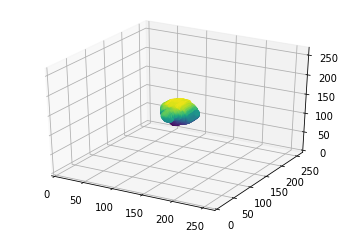

In [13]:
# Set which dataset to look at, and the index of the patient to view
dataset = training_data
index = 7

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

array = dataset[index][0].numpy()
x,y,z = np.where(array > -1024)
ax.scatter(x, y, z, c=z, alpha=1)
print(len(array))

ax.set_xlim(0,len(array))
ax.set_ylim(0,len(array))
ax.set_zlim(0,len(array))

# Data Loader

In [14]:
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = batch_size, shuffle = True)
# may need to put either test or validation as shuffle = False


# Define CNN Class

In [15]:
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.conv1 = nn.Conv3d(1, 6, 5) # 1 = number of input channels
    self.pool = nn.MaxPool3d(2, 2)
    self.conv2 = nn.Conv3d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 63 * 63 * 63, 120)
    self.fc2 = nn.Linear(120, 30)
    self.fc3 = nn.Linear(30, 2) #2 for 2 different output classes (dead or alive)

  def forward(self, x) :
    x = self.pool(F.relu(self.conv1(x))) # first conv and pooling layer
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 63 *63 * 63)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x= self.fc3(x)
    return x




In [16]:
model = CNN().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [1]:
n_total_steps = len(train_dataloader)

for epoch in range(num_epochs) :
  for i, (images,labels) in enumerate(train_dataloader) :
    images = reshape(images, (images.shape[0], 1 , 264, 264, 264))
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs,labels)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Step [{i+1}/{len(enumerate(train_dataloader))}], Loss: {loss.item():.4f}.")
print("Finished Training")

NameError: ignored

Some testing

In [19]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([4, 264, 264, 264])


In [ ]:
conv1 = nn.Conv3d(1, 6, 5)
pool = nn.MaxPool3d(2,2)
conv2 = nn.Conv3d(6,16,5)
print(images.shape)
images = reshape(images, (images.shape[0], 1 , 264, 264, 264))
print(images.shape)
x = conv1(images)
print(f"After conv1 : {x.shape}")
x = pool(x)
print(f"After pool : {x.shape}")
x = conv2(x)
print(f"After conv2 : {x.shape}")
x = pool(x)
print(f"After the 2nd pool : {x.shape}")


torch.Size([4, 264, 264, 264])
torch.Size([4, 1, 264, 264, 264])
